## 1. Import libraries and requirements

In [1]:
# Loading required packages
import spacy
import pandas as pd
import re
# import gensim
# import gensim.downloader
# from gensim.models import Word2Vec
# from gensim.test.utils import common_texts
# from gensim.models import Word2Vec
# from gensim.models.phrases import Phrases, Phraser
# import nltk
from numpy import mean
from numpy import std
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from statistics import mean
import json
import csv
import ast
import numpy as np

from flair.embeddings import WordEmbeddings
from flair.data import Sentence
from flair.embeddings import TransformerWordEmbeddings
from flair.embeddings import FastTextEmbeddings

# import fasttext
# import fasttext.util
# fasttext.util.download_model('en', if_exists='ignore')  # English

from tqdm import tqdm

# Set seed
seed = np.random.seed(1)


# Select Spacy model
# Efficiency
nlp = spacy.load("en_core_web_sm")

# Accuracy
# nlp = spacy.load("en_core_web_trf")

# Change working directory
# %cd '/Users/richardfrissen/Documents/Maastricht University/Thesis/Development/Datasets'

/opt/conda/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
# Define columns and read annotated data
columns = ['Token', 'Label', 'pos', 'ent_type', 'is_alpha', 'is_ascii', 'is_digit', 'is_lower', 'is_upper', 'is_title', 'is_punct', 'is_space', 'like_num', 'is_oov', 'is_stop', 'like_num', 'lang', 'sentiment']
data = pd.read_csv('FULL_Annotation_data_output.tsv', sep='\t', nrows=500000, header = None)

In [ ]:
%%time

# Generate linguistic features for each token
def feature_extraction(input_column):
    features = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    for i in tqdm(input_column):
        i = str(i)
        doc = nlp(i)
        word = i
        for token in doc:
            features[0].append(token.pos)
            features[1].append(token.ent_type)
            features[2].append(token.is_alpha)
            features[3].append(token.is_ascii)
            features[4].append(token.is_digit)
            features[5].append(token.is_lower)
            features[6].append(token.is_upper)
            features[7].append(token.is_title)
            features[8].append(token.is_punct)
            features[9].append(token.is_space)
            features[10].append(token.like_num)
            features[11].append(token.is_oov)
            features[12].append(token.is_stop)
            features[13].append(token.lang)
            features[14].append(token.sentiment)
            features[15].append(len(word))
    return features

features = feature_extraction(data[0])

In [ ]:
%%time

# Convert list to dataframe
features = pd.DataFrame(features)

# We need to transpose this dataframe first
features = features.transpose()

# We concat the annotated data with the linguistic features
data = pd.concat([data, features], axis=1)
data.columns = ['Token', 'Label', 'pos', 'ent_type', 'is_alpha', 'is_ascii', 'is_digit', 'is_lower', 'is_upper', 'is_title', 'is_punct', 'is_space', 'like_num', 'is_oov', 'is_stop', 'lang', 'sentiment', 'word_length']

data.head(10)

In [ ]:
# Optionally the data can be saved to create a checkpoint

data.to_csv('data_features_full_dataset.csv', index = False)

data = pd.read_csv('data_features_full_dataset.csv', nrows = 500000, header = 0)

data.shape

In [ ]:
data.head(10)

In [ ]:
# init word embedding
embedding = FastTextEmbeddings('cc.en.300.bin')

In [ ]:
%%time

# Generate word embeddings for each token

def fasttext_wordembed(input_column):
    fasttext_result =[]
    counter = 0
    for i in tqdm(input_column):
        counter = counter +1
        try:
            i = str(i)
            token = Sentence(i)
            embedding.embed(token)
            for token in token:
                result_array = token.embedding
            result_list = result_array.tolist()
            fasttext_result.append(result_list)
        except KeyError:
            fasttext_result.append(np.nan)
        except TypeError: 
            fasttext_result.append(np.nan)
        except IndexError:
            fasttext_result.append(np.nan)

    return fasttext_result


# fasttext_Word_Embeddings
word_embedding = fasttext_wordembed(data['Token'])

In [ ]:
len(word_embedding)

In [ ]:
# Optionally the data can be saved to create a checkpoint

import pickle

f = open('word_embedding_fasttext.pckl', 'wb')
pickle.dump(word_embedding, f)
f.close()

f = open('word_embedding_fasttext.pckl', 'rb')
word_embedding = pickle.load(f)
f.close()

In [ ]:
%%time

# Replace empty values in the list of word embeddings for words 
# we couldn't generate a word embedding for

word_embedding_complete = []

for i in tqdm(word_embedding):
    try:
        if len(i) == 0:
            i = []
        else:
            i = i
        word_embedding_complete.append(i)
        
    except TypeError:
        i = []
        word_embedding_complete.append(i)

In [ ]:
# Check and verify length
# Length must be the same as the nrows of the dataframe

len(word_embedding_complete)

In [ ]:
%%time

# Convert list to dataframe
word_embedding_df = pd.DataFrame(word_embedding_complete)
word_embedding_series = word_embedding_df.apply(pd.Series)

# We concat the annotated data with the linguistic features
data = pd.concat([data, word_embedding_series], axis=1)

In [ ]:
data.head(10)

In [2]:
%%time

# Optionally the data can be saved to create a checkpoint

# data.to_csv('data_features_full_wordembedding_fasttext.csv', index = False)

data = pd.read_csv('data_features_full_wordembedding_fasttext.csv', nrows = 500000, na_values=['nan'])

data.head(10)

CPU times: user 28 s, sys: 2.54 s, total: 30.6 s
Wall time: 34.2 s


,Token,Label,pos,ent_type,is_alpha,is_ascii,is_digit,is_lower,is_upper,is_title,...,290,291,292,293,294,295,296,297,298,299
0,food,O,92,0,True,True,False,True,False,False,...,-0.039578,0.047575,-0.058627,0.046259,0.023654,0.051156,-0.025376,0.194072,0.064826,-0.043009
1,a,O,90,0,True,True,False,True,False,False,...,0.428693,0.140281,-0.160824,0.140865,0.010901,-0.006161,-0.024191,0.534851,-0.055810,-0.016598
2,fast,O,86,0,True,True,False,True,False,False,...,0.088452,0.049980,-0.188911,0.008010,0.005692,0.030967,0.088043,0.132366,-0.068855,-0.109943
3,grow,O,100,0,True,True,False,True,False,False,...,0.079889,-0.001241,-0.078710,0.056499,-0.040299,0.026815,0.016724,0.003833,0.141033,0.139362
4,-winne,O,97,0,False,True,False,True,False,False,...,0.026260,-0.142785,-0.139935,0.030903,0.135329,-0.037944,-0.159724,0.062729,-0.032213,-0.062005
5,online,O,86,0,True,True,False,True,False,False,...,-0.011911,0.032228,-0.046799,-0.049946,-0.098857,0.027563,0.032633,0.078089,-0.021893,0.010680
6,food,O,92,0,True,True,False,True,False,False,...,-0.039578,0.047575,-0.058627,0.046259,0.023654,0.051156,-0.025376,0.194072,0.064826,-0.043009
7,community,O,92,0,True,True,False,True,False,False,...,0.001633,0.012280,-0.018961,0.068939,-0.038316,0.001767,0.018424,0.039195,0.033368,0.054643
8,and,O,89,0,True,True,False,True,False,False,...,0.060722,-0.035507,-0.023820,-0.027755,-0.026023,-0.038051,-0.021103,-0.011591,-0.041129,0.036252
9,crowd,O,92,0,True,True,False,True,False,False,...,0.037642,-0.092540,-0.013170,0.092988,0.080099,-0.030800,0.069824,0.092307,-0.001399,-0.007892


In [3]:
%%time

# Replace NaN values with a "0"

data = data.replace(np.nan, '0', regex=True)

# We drop the token, as it is no longer needed for prediction
data.drop('Token', axis=1, inplace=True)
data.head(10)

CPU times: user 400 ms, sys: 286 ms, total: 686 ms
Wall time: 691 ms


,Label,pos,ent_type,is_alpha,is_ascii,is_digit,is_lower,is_upper,is_title,is_punct,...,290,291,292,293,294,295,296,297,298,299
0,O,92,0,True,True,False,True,False,False,False,...,-0.039578,0.047575,-0.058627,0.046259,0.023654,0.051156,-0.025376,0.194072,0.064826,-0.043009
1,O,90,0,True,True,False,True,False,False,False,...,0.428693,0.140281,-0.160824,0.140865,0.010901,-0.006161,-0.024191,0.534851,-0.055810,-0.016598
2,O,86,0,True,True,False,True,False,False,False,...,0.088452,0.049980,-0.188911,0.008010,0.005692,0.030967,0.088043,0.132366,-0.068855,-0.109943
3,O,100,0,True,True,False,True,False,False,False,...,0.079889,-0.001241,-0.078710,0.056499,-0.040299,0.026815,0.016724,0.003833,0.141033,0.139362
4,O,97,0,False,True,False,True,False,False,False,...,0.026260,-0.142785,-0.139935,0.030903,0.135329,-0.037944,-0.159724,0.062729,-0.032213,-0.062005
5,O,86,0,True,True,False,True,False,False,False,...,-0.011911,0.032228,-0.046799,-0.049946,-0.098857,0.027563,0.032633,0.078089,-0.021893,0.010680
6,O,92,0,True,True,False,True,False,False,False,...,-0.039578,0.047575,-0.058627,0.046259,0.023654,0.051156,-0.025376,0.194072,0.064826,-0.043009
7,O,92,0,True,True,False,True,False,False,False,...,0.001633,0.012280,-0.018961,0.068939,-0.038316,0.001767,0.018424,0.039195,0.033368,0.054643
8,O,89,0,True,True,False,True,False,False,False,...,0.060722,-0.035507,-0.023820,-0.027755,-0.026023,-0.038051,-0.021103,-0.011591,-0.041129,0.036252
9,O,92,0,True,True,False,True,False,False,False,...,0.037642,-0.092540,-0.013170,0.092988,0.080099,-0.030800,0.069824,0.092307,-0.001399,-0.007892


In [4]:
%%time

# 80% / 20% split
# Train, Test = train_test_split(data1, test_size=0.2, shuffle=False)

X = data.drop(['Label'],axis=1).values # independant features
y = data['Label'].values # dependant variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

CPU times: user 4.76 s, sys: 3.43 s, total: 8.19 s
Wall time: 8.35 s


In [5]:
# Delete data to save memory

del(data)

In [6]:
X_train.shape, y_train.shape

((400000, 316), (400000,))

In [7]:
X_test.shape, y_test.shape

((100000, 316), (100000,))

In [8]:
%%time

max_iterations = 1000000000

classifier = []
accuracy = []
precision = []
recall = []
f1 = []

CPU times: user 7 µs, sys: 4 µs, total: 11 µs
Wall time: 21.7 µs


In [9]:
%%time
# Baseline

clf = DummyClassifier(strategy="uniform", random_state=seed)


# Model fit
clf.fit(X_train, y_train)

CPU times: user 207 ms, sys: 5.13 ms, total: 213 ms
Wall time: 218 ms


DummyClassifier(strategy='uniform')

In [10]:
# Optionally the data can be saved to create a checkpoint - Baseline

import pickle

f = open('fasttext_baseline.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('fasttext_baseline.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.16662
Precision: 0.16669788143411368
Recall: 0.16315833387324433
F1_score: 0.05833372562723548


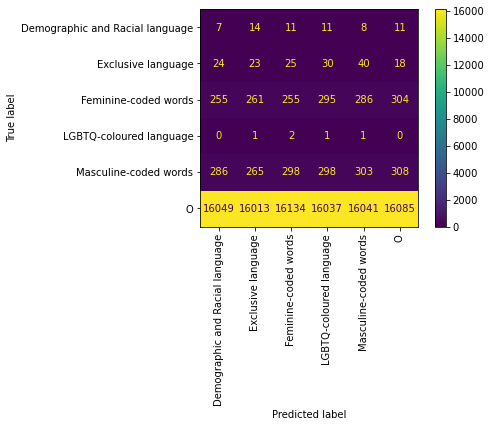

                                 precision    recall  f1-score   support

Demographic and Racial language       0.00      0.15      0.00        62
             Exclusive language       0.00      0.13      0.00       160
           Feminine-coded words       0.02      0.18      0.03      1656
        LGBTQ-coloured language       0.00      0.20      0.00         5
          Masculine-coded words       0.02      0.15      0.03      1758
                              O       0.96      0.17      0.28     96359

                       accuracy                           0.17    100000
                      macro avg       0.17      0.16      0.06    100000
                   weighted avg       0.93      0.17      0.27    100000



In [11]:
# Evaluation Baseline

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("Baseline")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [9]:
%%time

# Find optimal SVM parameters

# from sklearn import svm
# from sklearn.model_selection import GridSearchCV

# Cs = [0.001, 0.01, 0.1, 1, 10]
# gammas = [0.001, 0.01, 0.1, 1]
# param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': ('linear', 'rbf', 'poly', 'sigmoid')}
# grid_search = GridSearchCV(svm.SVC(random_state=seed), param_grid, cv=10, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# print(grid_search.best_params_)

CPU times: user 6 µs, sys: 4 µs, total: 10 µs
Wall time: 20 µs


In [10]:
%%time
# Support Vector Machine
# best: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = svm.SVC(kernel='rbf', random_state=seed, max_iter=max_iterations, C=10, gamma=1)
scores_SVM = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
SVM_avg_precision = mean(scores_SVM['test_precision_macro'])
SVM_avg_recall = mean(scores_SVM['test_recall_macro'])
SVM_avg_f1 = mean(scores_SVM['test_f1_macro'])

print(SVM_avg_precision)
print(SVM_avg_recall)
print(SVM_avg_f1)

# Model fit
clf.fit(X_train, y_train)

0.18779070076944282
0.43055616287124693
0.10323267237846241
CPU times: user 45min 5s, sys: 1min 8s, total: 46min 14s
Wall time: 1h 46min 51s


SVC(C=10, gamma=1, max_iter=1000000000)

In [12]:
# Optionally the data can be saved to create a checkpoint - SVM

import pickle

f = open('fasttext_svm.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('fasttext_svm.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.2625
Precision: 0.1883795941324606
Recall: 0.3991002779502209
F1_score: 0.10376520444727795


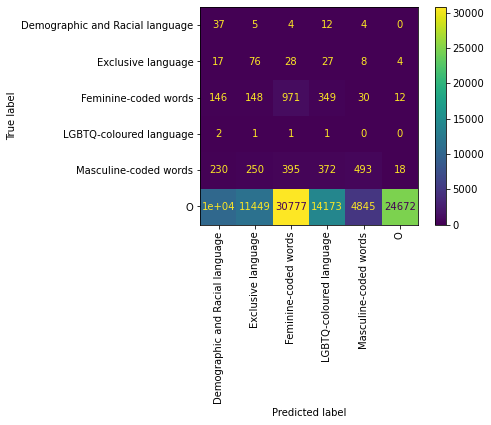

                                 precision    recall  f1-score   support

Demographic and Racial language       0.00      0.60      0.01        62
             Exclusive language       0.01      0.47      0.01       160
           Feminine-coded words       0.03      0.59      0.06      1656
        LGBTQ-coloured language       0.00      0.20      0.00         5
          Masculine-coded words       0.09      0.28      0.14      1758
                              O       1.00      0.26      0.41     96359

                       accuracy                           0.26    100000
                      macro avg       0.19      0.40      0.10    100000
                   weighted avg       0.96      0.26      0.40    100000



In [13]:
# Evaluation Support Vector Machine

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("SVM")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [ ]:
%%time

# Find optimal Logistic Regression settings

# from sklearn import svm
# from sklearn.model_selection import GridSearchCV

# Cs = [0.001, 0.01, 0.1, 1, 10]
# penaltys = ['l1', 'l2', 'elasticnet']
# param_grid = {'C': Cs, 'penalty' : penaltys, 'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
# grid_search = GridSearchCV(LogisticRegression(random_state=seed), param_grid, cv=10, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# print(grid_search.best_params_)

In [13]:
%%time

# Logistic Regression

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = LogisticRegression(solver='newton-cg', random_state=seed, max_iter=max_iterations)
scores_LR = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
LR_avg_precision = mean(scores_LR['test_precision_macro'])
LR_avg_recall = mean(scores_LR['test_recall_macro'])
LR_avg_f1 = mean(scores_LR['test_f1_macro'])

print(LR_avg_precision)
print(LR_avg_recall)
print(LR_avg_f1)

# Model fit
clf.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not

0.16036208333333332
0.16666666666666666
0.16345360393227235
CPU times: user 47min 3s, sys: 49min, total: 1h 36min 4s
Wall time: 10min


/opt/conda/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


LogisticRegression(max_iter=1000000000, solver='newton-cg')

In [14]:
# Optionally the data can be saved to create a checkpoint - LR

import pickle

f = open('fasttext_lr.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('fasttext_lr.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.96359
Precision: 0.16059833333333332
Recall: 0.16666666666666666
F1_score: 0.1635762387599584


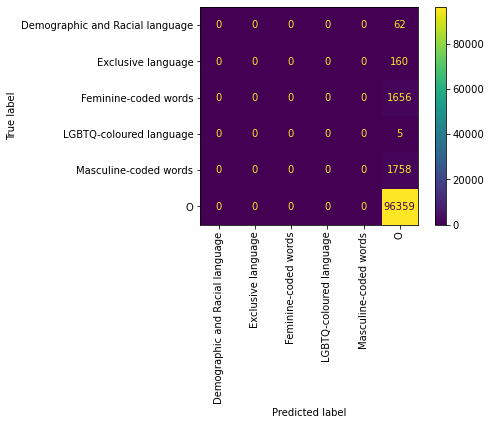

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

Demographic and Racial language       0.00      0.00      0.00        62
             Exclusive language       0.00      0.00      0.00       160
           Feminine-coded words       0.00      0.00      0.00      1656
        LGBTQ-coloured language       0.00      0.00      0.00         5
          Masculine-coded words       0.00      0.00      0.00      1758
                              O       0.96      1.00      0.98     96359

                       accuracy                           0.96    100000
                      macro avg       0.16      0.17      0.16    100000
                   weighted avg       0.93      0.96      0.95    100000



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# Evaluation Logistic Regression

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("LR")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [16]:
%%time

# Decision Tree

# Cross validation
scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = DecisionTreeClassifier(random_state=seed)
scores_DT = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
DT_avg_precision = mean(scores_DT['test_precision_macro'])
DT_avg_recall = mean(scores_DT['test_recall_macro'])
DT_avg_f1 = mean(scores_DT['test_f1_macro'])

print(DT_avg_precision)
print(DT_avg_recall)
print(DT_avg_f1)

# Model fit
clf.fit(X_train, y_train)

0.9780919645875654
0.991728058416767
0.9844331376512876
CPU times: user 4min 41s, sys: 59.2 s, total: 5min 40s
Wall time: 9min 16s


DecisionTreeClassifier()

In [16]:
# Optionally the data can be saved to create a checkpoint - DT

import pickle

f = open('fasttext_dt.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('fasttext_dt.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.9993
Precision: 0.9762266865549822
Recall: 0.928746140349066
F1_score: 0.943802597209952


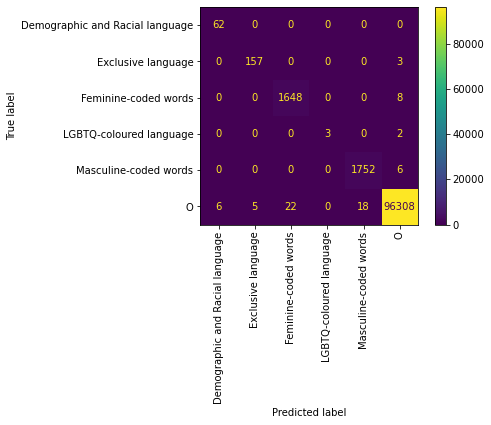

                                 precision    recall  f1-score   support

Demographic and Racial language       0.91      1.00      0.95        62
             Exclusive language       0.97      0.98      0.98       160
           Feminine-coded words       0.99      1.00      0.99      1656
        LGBTQ-coloured language       1.00      0.60      0.75         5
          Masculine-coded words       0.99      1.00      0.99      1758
                              O       1.00      1.00      1.00     96359

                       accuracy                           1.00    100000
                      macro avg       0.98      0.93      0.94    100000
                   weighted avg       1.00      1.00      1.00    100000



In [17]:
# Evaluation Decision Tree

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("DT")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [19]:
%%time

# Random Forest

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = RandomForestClassifier(random_state=seed)
scores_RF = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
RF_avg_precision = mean(scores_RF['test_precision_macro'])
RF_avg_recall = mean(scores_RF['test_recall_macro'])
RF_avg_f1 = mean(scores_RF['test_f1_macro'])

print(RF_avg_precision)
print(RF_avg_recall)
print(RF_avg_f1)

# Model fit
clf.fit(X_train, y_train)

0.9976285300864541
0.9900472607315337
0.9935529947449463
CPU times: user 7min 50s, sys: 59.9 s, total: 8min 50s
Wall time: 15min 45s


RandomForestClassifier()

In [18]:
# Optionally the data can be saved to create a checkpoint - RF

import pickle

f = open('fasttext_rf.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('fasttext_rf.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.9997
Precision: 0.9962507084045193
Recall: 0.928914240547166
F1_score: 0.9542237112758416


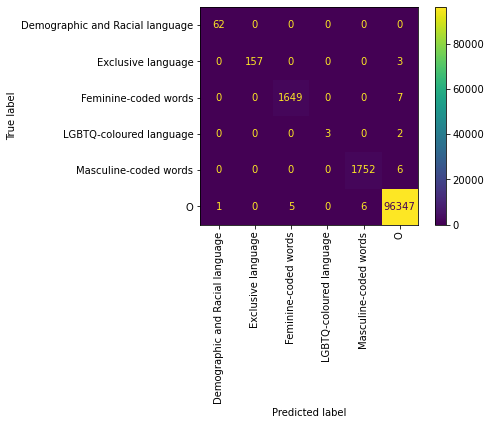

                                 precision    recall  f1-score   support

Demographic and Racial language       0.98      1.00      0.99        62
             Exclusive language       1.00      0.98      0.99       160
           Feminine-coded words       1.00      1.00      1.00      1656
        LGBTQ-coloured language       1.00      0.60      0.75         5
          Masculine-coded words       1.00      1.00      1.00      1758
                              O       1.00      1.00      1.00     96359

                       accuracy                           1.00    100000
                      macro avg       1.00      0.93      0.95    100000
                   weighted avg       1.00      1.00      1.00    100000



In [19]:
# Evaluation Random Forest

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("RF")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [ ]:
%%time

# Find optimal Neural network MLP settings

# from sklearn import svm
# from sklearn.model_selection import GridSearchCV

# activations = ['identity', 'logistic', 'tanh', 'relu']
# alphas = [0.0001, 0.001, 00.1, 0.1, 1]
# param_grid = {'activation': activations, 'alpha' : alphas, 'solver': ('lbfgs', 'sgd', 'adam'), 'learning_rate': ('constant', 'invscaling', 'adaptive')}
# grid_search = GridSearchCV(MLPClassifier(random_state=seed), param_grid, cv=10, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# print(grid_search.best_params_)

In [22]:
%%time

# Neural network MLP

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = MLPClassifier(solver='adam', random_state=seed)
scores_NN = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
NN_avg_precision = mean(scores_NN['test_precision_macro'])
NN_avg_recall = mean(scores_NN['test_recall_macro'])
NN_avg_f1 = mean(scores_NN['test_f1_macro'])

print(NN_avg_precision)
print(NN_avg_recall)
print(NN_avg_f1)

# Model fit
clf.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Pr

0.16128875740643514
0.1666670997133231
0.14769125450913934
CPU times: user 1h 24min 54s, sys: 3h 25min 40s, total: 4h 50min 35s
Wall time: 9min 49s


MLPClassifier()

In [20]:
# Optionally the data can be saved to create a checkpoint - MLP

import pickle

f = open('fasttext_mlp.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('fasttext_mlp.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.96359
Precision: 0.16059833333333332
Recall: 0.16666666666666666
F1_score: 0.1635762387599584


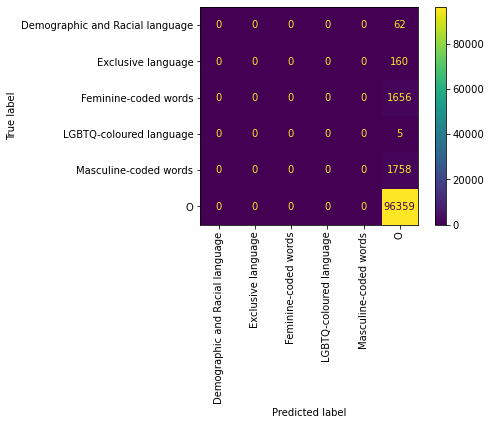

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

Demographic and Racial language       0.00      0.00      0.00        62
             Exclusive language       0.00      0.00      0.00       160
           Feminine-coded words       0.00      0.00      0.00      1656
        LGBTQ-coloured language       0.00      0.00      0.00         5
          Masculine-coded words       0.00      0.00      0.00      1758
                              O       0.96      1.00      0.98     96359

                       accuracy                           0.96    100000
                      macro avg       0.16      0.17      0.16    100000
                   weighted avg       0.93      0.96      0.95    100000



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Evaluation Neural network MLP

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("MLP")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [25]:
%%time

# Naive Bayes

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = GaussianNB()
scores_NB = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
NB_avg_precision = mean(scores_NB['test_precision_macro'])
NB_avg_recall = mean(scores_NB['test_recall_macro'])
NB_avg_f1 = mean(scores_NB['test_f1_macro'])

print(NB_avg_precision)
print(NB_avg_recall)
print(NB_avg_f1)

# Model fit
clf.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Pr

0.11970472004188243
0.16667446151773477
0.005982920730818852
CPU times: user 1min 8s, sys: 57.7 s, total: 2min 6s
Wall time: 2min 34s


GaussianNB()

In [22]:
# Optionally the data can be saved to create a checkpoint - NB

import pickle

f = open('fasttext_nb.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('fasttext_nb.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.0166
Precision: 0.16942677707108286
Recall: 0.16667358523853507
F1_score: 0.005444128152409039


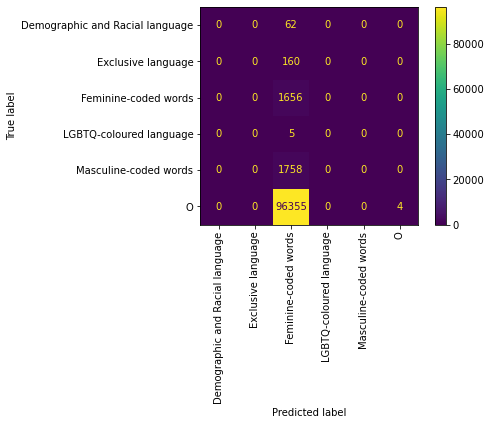

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

Demographic and Racial language       0.00      0.00      0.00        62
             Exclusive language       0.00      0.00      0.00       160
           Feminine-coded words       0.02      1.00      0.03      1656
        LGBTQ-coloured language       0.00      0.00      0.00         5
          Masculine-coded words       0.00      0.00      0.00      1758
                              O       1.00      0.00      0.00     96359

                       accuracy                           0.02    100000
                      macro avg       0.17      0.17      0.01    100000
                   weighted avg       0.96      0.02      0.00    100000



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# Evaluation Naive Bayes

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("NB")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [24]:
results = pd.DataFrame(zip(classifier, accuracy, precision, recall, f1), columns = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
results = results.sort_values(by = "F1-score", ascending = False)

f = open('fasttext_results.pckl', 'wb')
pickle.dump(results, f)
f.close()

f = open('fasttext_results.pckl', 'rb')
results = pickle.load(f)
f.close()

print(results)

  Classifier  Accuracy  Precision    Recall  F1-score
4         RF   0.99970   0.996251  0.928914  0.954224
3         DT   0.99930   0.976227  0.928746  0.943803
2         LR   0.96359   0.160598  0.166667  0.163576
5        MLP   0.96359   0.160598  0.166667  0.163576
1        SVM   0.26250   0.188380  0.399100  0.103765
0   Baseline   0.16662   0.166698  0.163158  0.058334
6         NB   0.01660   0.169427  0.166674  0.005444


In [26]:
# Save results dataframe

results.to_csv('fasttext_results.csv', index = False)

In [ ]:
# %%time

# from sklearn.model_selection import train_test_split
# from sklearn.datasets import load_breast_cancer
# from sklearn.neighbors import KNeighborsClassifier
# import matplotlib.pyplot as plt

# %matplotlib inline

# # We create two lists to keep training and test accuracies. We'll later use them to evaluate an 
# # appropriate number of neighbors
# training_accuracy = []
# test_accuracy = []

# # We define a range of 1 to 10 (included) neighbors that will be tested
# neighbors_settings = range(1,11)

# # We loop the KNN model through the range of possible neighbors to evaluate which one would be 
# # appropriate for this analysis

# for n_neighbors in neighbors_settings:
    
#     # creating the KNN classifier
#     clf = KNeighborsClassifier(n_neighbors=n_neighbors)
#     # fitting the model
#     clf.fit(X_train, y_train)
#     #recording the accuracy of the training set
#     training_accuracy.append(clf.score(X_train, y_train))
#     #recording the accuracy of the test set
#     test_accuracy.append(clf.score(X_test, y_test))
    
# # Data Visualization - Evaluating the accuracy of both the training and the testing sets against 
# # n_neighbors
    
# plt.plot(neighbors_settings, training_accuracy, label='Accuracy of the Training Set')
# plt.plot(neighbors_settings, test_accuracy, label='Accuracy of the Test Set')
# plt.ylabel('Accuracy')
# plt.xlabel('Number of Neighbors')
# plt.legend()

In [ ]:
# LR = LogisticRegression(solver='lbfgs', max_iter=self.iter,random_state=self.seed, n_jobs=self.processor_mode)

# GBC = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=self.seed)

# SGD = SGDClassifier(loss="hinge", penalty="l2", max_iter=self.iter,random_state=self.seed, n_jobs=self.processor_mode)

# RF = RandomForestClassifier(random_state=self.seed, n_jobs=self.processor_mode)

# SVM = svm.SVC(decision_function_shape='ovo',random_state=self.seed)

# MLP = MLPClassifier(solver='lbfgs', alpha=1e-5,
#              hidden_layer_sizes=(15,), random_state=self.seed,max_iter=self.iter)